# __Predicting Sale Price of homes in Ames, Iowa using Linear Regression and Regularization__
---

## Problem Statement
Large purchases, such as buying a home, carry inherent risks that may be unforseen when buyers have incomplete information. Accurate predictions in home prices could mean the difference between a risky investment and a dream home. By providing a benchmark for a home's true value, both buyer and seller can feel confident a fair purchase is taking place.  

The value of a house is not easily summarized in a few lines. Buyers and sellers considers multiple aspects of a property when considering the overall cost of the lot. If a model could accurately predict a home's sale prices, the variables involved would show what the most important aspects of a house are. So, what variables about a house are needed to make an accurate prediction of it's sale price?

## Executive Summary
These data were provided by General Assembly, parsed from the Ames Iowa Housing Dataset, publicly available for use. This 
dataset was originally created by Dr. Dean DeCock, Professor of Statistics at Truman State University - [source](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt).  

Initially, I assumed the best predictions would come from a simple model including 3 key components: house quality, house size, and house age. However, these factors failed to account for the more granular affects on a house's sale price. I learned quite quickly if a variable plays even a small role in the determining the target, it should be included in the model, since the coefficient will essentially take care of the overall influence the variable plays.

Feature engineering was also something I struggled with. I intially only created one variable, house age, and then I made thousands of interaction terms. I discovered through research and speaking with others, engineered features should be __interpretable__ and relate to the problem in context. Failing to do so is akin to throwing "garbage" or random noise into the model, which will contribute to overfitting and an overall poorer model.

Although this problem was intended for a [Kaggle Contest](https://www.kaggle.com/c/dsi-us-8-project-2-regression-challenge), it ultimately served as a challenge for myself to rethink how I understood data. On multiple occasions I had to go backwards through my workflow in order to correct assumptions I made or faulty understandings of the data.

## Table of Contents
- [Imports](#Imports)
- [Loading Data](#Loading-Data)
- [Macro Exploration](#Macro-Exploration)
- [Data Cleaning](#Data-Cleaning)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Feature Engineering](#Feature-Engineering)
- [Model Preparation](#Model-Preparation)
- [Fitting Model](#Fitting-Model)
- [Model Evaluation](#Model-Evaluation)
- [Inferrential Statistics and Conclusions](#Inferrential-Statistics-and-Conclusions)
- [Kaggle Submission](#Kaggle-Submission)
- [Sources](#Sources)

## Imports

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

import warnings
warnings.filterwarnings('ignore') # Shhhhhhhhhh

## Loading Data

In [3]:
train = pd.read_csv("datasets/train.csv", index_col=0)
kaggle_test = pd.read_csv("datasets/test.csv", index_col=0)

## Macro Exploration

In [4]:
train.head(2)

,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000


In [5]:
train.shape

(2051, 80)

In [6]:
kaggle_test.shape

(879, 79)

The goal of this competition is to submit the best model we can with the lowest RMSE score.  

The submission is done through a .csv file containing the predicted values for the missing column in the provided `kaggle_test` dataset (the missing column is `SalePrice`).

## Data Cleaning

### Handling missing values
Initially, it looks like the provided dataset is full of missing values

In [7]:
all_nulls = train.isnull().sum()
all_nulls[all_nulls > 0]

Lot Frontage       330
Alley             1911
Mas Vnr Type        22
Mas Vnr Area        22
Bsmt Qual           55
Bsmt Cond           55
Bsmt Exposure       58
BsmtFin Type 1      55
BsmtFin SF 1         1
BsmtFin Type 2      56
BsmtFin SF 2         1
Bsmt Unf SF          1
Total Bsmt SF        1
Bsmt Full Bath       2
Bsmt Half Bath       2
Fireplace Qu      1000
Garage Type        113
Garage Yr Blt      114
Garage Finish      114
Garage Cars          1
Garage Area          1
Garage Qual        114
Garage Cond        114
Pool QC           2042
Fence             1651
Misc Feature      1986
dtype: int64

However, upon further inspection of the [Data Dictionary](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt), many categorical variables simply use "NA" to describe when a house part is not on the premises - in effect these values are not truly missing, but rather convey information.  

I will fill in categorical variables properly with a string value denoting a missing house component, while imputing the median value for numeric variables.

In [8]:
# select all null numeric columns
numeric_null_counts = train._get_numeric_data().isnull().sum()
numeric_null_names = numeric_null_counts[numeric_null_counts>0].index

# Filling null numeric columns with median values
for col_name in numeric_null_names:
    train[col_name].fillna(train[col_name].median(), inplace=True)
    kaggle_test[col_name].fillna(kaggle_test[col_name].median(), inplace=True)

# Fill remaining categorical columns with meaningful "NA" values
train.fillna("NA", inplace = True)
kaggle_test.fillna("NA", inplace = True)

### Garage from the future...?
Looking at the `Garage Yr Blt` feature, we find a strange maximum  
_Credit to Rose Tesoriero Montoya for her insights on handling this erroneous data point_

In [9]:
train["Garage Yr Blt"].describe()

count    2051.000000
mean     1978.779620
std        24.725364
min      1895.000000
25%      1962.000000
50%      1980.000000
75%      2001.000000
max      2207.000000
Name: Garage Yr Blt, dtype: float64

There is only one data point with this impossible value. I've decided to drop it from the dataset. 

In [10]:
impossibles = train[train["Garage Yr Blt"] > 2019].index
impossibles

Int64Index([2261], dtype='int64', name='Id')

In [11]:
train.drop(index = impossibles, inplace = True)

## Exploratory Data Analysis

### The target - `SalePrice`
As the main focus of the problem, it's important to explore the target, `SalePrice`.

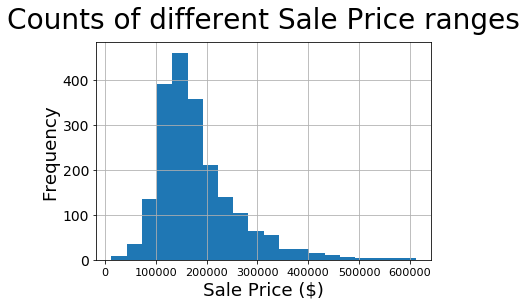

In [12]:
size = 14
plt.figure(figsize=(6,4))
plt.title("Counts of different Sale Price ranges", fontsize = size * 2, pad = size)
plt.xlabel("Sale Price ($)", fontsize = size * 1.3)
plt.ylabel("Frequency", fontsize = size * 1.3)
plt.xticks(size = size * 4/5)
plt.yticks(size = size)
train["SalePrice"].hist(bins = 20);

Here, we see `SalePrice` is clearly skewed, a common trend when working with money.  

A simple log transformation can help ensure the linear regression adheres to the assumption that the continuous target is normally distributed.

In [13]:
train["log_saleprice"] = np.log(train["SalePrice"])
target = "log_saleprice"

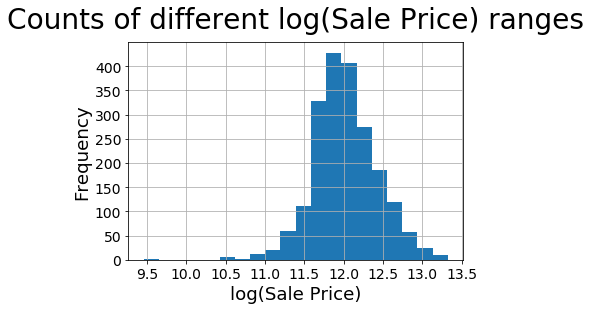

In [14]:
plt.figure(figsize=(6,4))
plt.title("Counts of different log(Sale Price) ranges", fontsize = size * 2, pad = size)
plt.xlabel("log(Sale Price)", fontsize = size * 1.3)
plt.ylabel("Frequency", fontsize = size * 1.3)
plt.xticks(size = size)
plt.yticks(size = size)
train["log_saleprice"].hist(bins=20);

### Handling Extreme Sale Prices
I found 14 data points that significantly deviated from the average log(sale price).  
After much consideration, I decided to remove these extreme cases in order to develop a better fit model.

In [15]:
def getExtremes(df, col_name, max_std = 3):
    mean = df[col_name].mean() 
    std_max = df[col_name].std() * max_std
    too_high = mean + std_max
    too_low = mean - std_max

    extreme = df[(df[col_name] > too_high) | (df[col_name] < too_low)]
    return extreme

In [16]:
extreme_prices = getExtremes(train, "log_saleprice")
extreme_prices["SalePrice"].sort_values()

Id
182      12789
1554     13100
727      34900
2844     35000
2881     35311
710      37900
1902     39300
1556     40000
728      44000
709      45000
434     582933
2451    584500
1638    591587
45      611657
Name: SalePrice, dtype: int64

In [17]:
train.drop(index=extreme_prices.index, inplace = True)

Moving forward, I must consider the ramifications of eliminating these extreme target values. In essense, _my model will better able to predict sale prices for a typical home, while being less accurate at predicting the sales prices for extremely low or high value homes._  

Given the rarity of these cases, I feel confident in making this trade off.

### Preliminary Feature Correlations
Before diving straight into engineering features, we can gain insight into which features naturally correlate with the target.

In [18]:
# CONFIG
size = 16

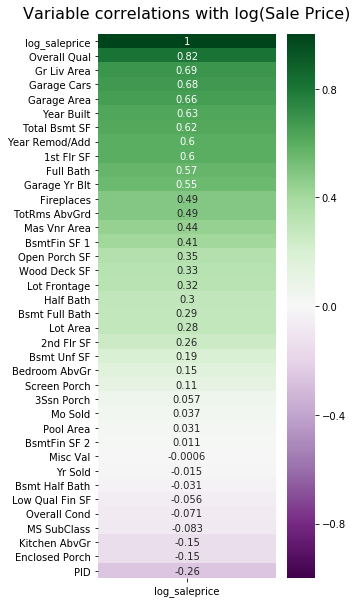

In [19]:
plt.figure(figsize=(4,10))
plt.title("Variable correlations with log(Sale Price)", fontsize = 16, pad = size)
corr = train.drop(columns = ["SalePrice"]).corr()
filtered_corr = corr.sort_values(target, ascending = False)
sns.heatmap(filtered_corr[[target]], vmin = -1, annot = True, cmap="PRGn");

These correlations make some intuitive sense.  
1. We can clearly see a houses general quality is correlated with higher sale price.
2. Similarly, a houses overall area plays a significant role, too. The larger the area, the higher the sale price.
3. The year built, or more simply the age of the house, plays a large role as well.
4. There are many other smaller variables that play a clear role, such as number of fireplaces, baths, etc.

At first glance there inevitably will be _multicollinearity_ between many of these variables. For example, the number of bedrooms will tend to be proportional to the size of the house. Likewise, the quality in one area of the house will likely correlate with high quality elsewhere. 

__Moving forward, I must keep this consideration of collinearity in mind as I apply a linear regression model to these data.__

## Feature Engineering
In order to keep track of which features I want to ignore, I'll be keeping a running list.

In [20]:
ignore_cols = [
    "PID",
    "SalePrice"
]

### House Age
For this feature, I simply subtract the year the house was sold by the year the house was built.

In [21]:
train["house_age"] = train["Yr Sold"] - train["Year Built"]
kaggle_test["house_age"] = kaggle_test["Yr Sold"] - kaggle_test["Year Built"]
ignore_cols += ["Yr Sold","Year Built"]

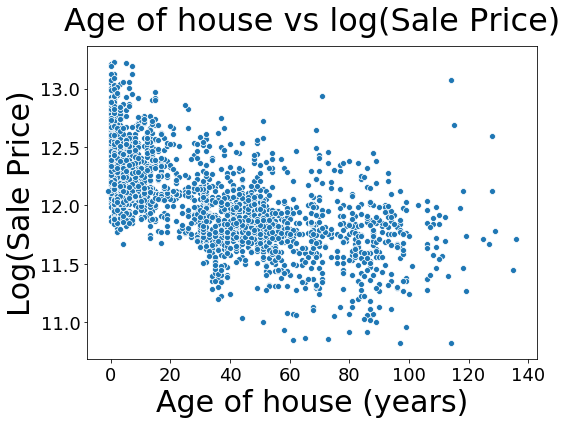

In [22]:
plt.figure(figsize=(8,6))
plt.title("Age of house vs log(Sale Price)", fontsize = size * 2, pad = size)
g = sns.scatterplot(train["house_age"], train["log_saleprice"]);
g.set_xlabel("Age of house (years)", size = 30)
g.set_ylabel("Log(Sale Price)", size= 30)
g.tick_params(labelsize=18)
plt.tight_layout()

We see a fairly noticeable correlation between the age of a house and it's sale price; the older the house, the lower the sale price tends to be.

### House Total Area
When looking at the correlations, it was clear area was correlated with sals price, however the total area was not being taken into account. This variable simply adds together all of the relevant variables regarding area.  

_NOTE: it only later can to my attention I was double counting the ground living area and the 1st floor surface area, however this may have helped to overemphasis these important features in the model._

In [23]:
house_area_variables = [
    "Total Bsmt SF",
    "1st Flr SF",
    "2nd Flr SF",
    "Gr Liv Area",
    "Garage Area",
    "Wood Deck SF",
    "Open Porch SF",
    "Pool Area"
]
 
train["house_total_area"] = train[house_area_variables].apply(sum,axis=1)
kaggle_test["house_total_area"] = kaggle_test[house_area_variables].apply(sum,axis=1)
ignore_cols += house_area_variables

_NOTE: after running a few models, it became clear outliers were having a significant effect on the model. I ended up removing 2 houses with and exceptionally large total area_

In [24]:
# Removing Outliers
train.drop(index = train[train["house_total_area"] > 15000].index, inplace=True)

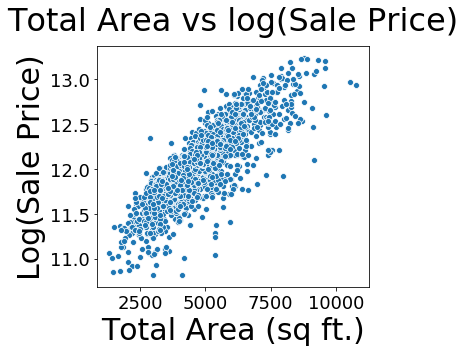

In [25]:
plt.figure(figsize=(6,5))
plt.title("Total Area vs log(Sale Price)", fontsize = size * 2, pad = size)
g = sns.scatterplot(train["house_total_area"], train["log_saleprice"]);
g.set_xlabel("Total Area (sq ft.)", size = 30)
g.set_ylabel("Log(Sale Price)", size= 30)
g.tick_params(labelsize=18)
plt.tight_layout()

We see a fairly strong correlation between a house's total area and it's sale price; the larger the area, the higher the price tends to be.

### House Total Baths
The variables related to baths were split into 4 separate variables. This engineered feature simply totals them up, while taking into account whether a bath is "Full" or "Half". "Half" baths contributed as .5 of their total.

In [26]:
full_bath_count_variables = ["Bsmt Full Bath","Full Bath"]
half_bath_count_variables = ["Bsmt Half Bath","Half Bath"]

train["house_total_baths"] = train[full_bath_count_variables].apply(sum,axis=1) + train[half_bath_count_variables].apply(sum,axis=1) * .5
kaggle_test["house_total_baths"] = kaggle_test[full_bath_count_variables].apply(sum,axis=1) + kaggle_test[half_bath_count_variables].apply(sum,axis=1) * .5
ignore_cols += full_bath_count_variables + half_bath_count_variables

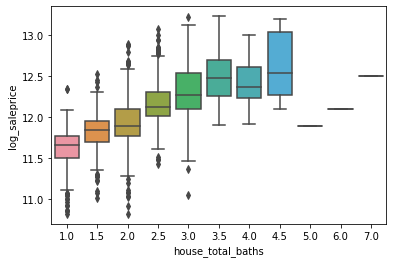

In [27]:
sns.boxplot(train["house_total_baths"], train["log_saleprice"]);

We see a clear correlation between the total number of baths and a house's sale price.

### `createInteraction` Helper Function

At this point, many of the features I wish to engineer follow a similar pattern, to which I created a helper function.  

The `createInteraction` simply takes two dataframes and creates the interaction terms in both. If a conversion dictionary is supplied, the column named will be converted using that dictionary before creating the interaction.

In [28]:
def createInteraction(df, test_df, interactions, new_col_name, conversion_dict = {}):
    if len(conversion_dict):
        if(df[interactions[0]].dtype.name=="object"):
            df[interactions[0]] = df[interactions[0]].map(conversion_dict)
            test_df[interactions[0]] = test_df[interactions[0]].map(conversion_dict)
        if(df[interactions[1]].dtype.name=="object"):
            test_df[interactions[1]] = test_df[interactions[1]].map(conversion_dict)
            df[interactions[1]] = df[interactions[1]].map(conversion_dict)            

    df[new_col_name]      = df[interactions[0]] * df[interactions[1]]
    test_df[new_col_name] = test_df[interactions[0]] * test_df[interactions[1]]
    
    if len(conversion_dict) == 3:
        df[new_col_name]      = df[new_col_name] * df[interactions[2]]
        test_df[new_col_name] = test_df[new_col_name] * test_df[interactions[2]]
        

#### Establishing conversion dictionaries

In [29]:
# Po-Ex
po_ex_dict = {
    "Ex": 4,
    "Gd": 3,
    "TA": 2,
    "Fa": 1,
    "Po": 0 
}

# NA-Ex
na_ex_dict = {
    "Ex": 5,
    "Gd": 4,
    "TA": 3,
    "Fa": 2,
    "Po": 1,
    "NA": 0
}

# NA-GLQ
na_glq = {
    "GLQ": 6,
    "ALQ": 5,
    "BLQ": 4,
    "Rec": 3,
    "LwQ": 2,
    "Unf": 1,
    "NA": 0
}

### Simple conversions
The following variables were simply converted from categorical to numeric ordinal.

In [30]:
# Central Air conversion
train["Central Air"].replace({"Y":1,"N":0}, inplace=True)
kaggle_test["Central Air"].replace({"Y":1,"N":0}, inplace=True)

# Pool QC
train["Pool QC"] = train["Pool QC"].map(na_ex_dict)
kaggle_test["Pool QC"] = kaggle_test["Pool QC"].map(na_ex_dict)

# Heating QC
train["Heating QC"] = train["Heating QC"].map(po_ex_dict)
kaggle_test["Heating QC"] = kaggle_test["Heating QC"].map(po_ex_dict)

### Quality * Condition = Score
These features put quality and condition on the same scale.

For example: A high quality house in excellent condition is distinguishable from another high quality house in poor condition.

In [31]:
# Quality Score
createInteraction(train, kaggle_test, ("Overall Qual", "Overall Cond"), "qual_score")

# Exterior Score
createInteraction(train, kaggle_test, ("Exter Qual", "Exter Cond"), "ext_score", po_ex_dict)

# Bsmt Score
createInteraction(train, kaggle_test, ("Bsmt Qual", "Bsmt Cond"), "bsmt_score", na_ex_dict)

### Quality + Area/Count = Score
These features put quality and area or count on the same scale.

For example: Five low-quality fireplaces might be comprarable to one high-quality fireplace.

In [32]:
# BsmtFin 1
createInteraction(train, kaggle_test, ("BsmtFin Type 1", "BsmtFin SF 1"), "bsmt_fin1_score", na_glq)

# BsmtFin 2
createInteraction(train, kaggle_test, ("BsmtFin Type 2", "BsmtFin SF 2"), "bsmt_fin2_score", na_glq)

# Garage Score
createInteraction(train, kaggle_test, ("Garage Qual", "Garage Cond","Garage Area"), "garage_score", na_ex_dict)

# Fireplace Score
createInteraction(train, kaggle_test, ("Fireplaces", "Fireplace Qu"), "fireplace_score", na_ex_dict) 

# Kitchen Score
createInteraction(train, kaggle_test, ("Kitchen AbvGr", "Kitchen Qual"), "kitchen_score", po_ex_dict) 

### `createDummies` Helper Function
In order to facilitate converting categorical variables into numeric dummy variables, I created the `createDummies` function.  

Pandas has a method for creating dummy variables, however, in this unique situation, the test set and training set had categories not seen in both datasets. This would cause a problem when fitting the model, since the features must be consistent in both.  

This function takes into account all categories seen in both given datasets and creates columns for all of them (minus 1, since this function drops the first category by default)

In [33]:
def createDummies(df_train, df_test, dummy_variables):
    for dummy_var in dummy_variables:
        # getting unique from both datasets
        unique_vals = list(set(df_train[dummy_var].unique()) and set(df_test[dummy_var].unique()))[1:] # Dropping first by default
        for val in unique_vals:
            col_name = "_".join(dummy_var.split()) + "_" + "_".join(str(val).split())
            df_train[col_name] = (df_train[dummy_var].values == val).astype("int")
            df_test[col_name] = (df_test[dummy_var].values == val).astype("int")

        df_train.drop(columns = [dummy_var], inplace = True)
        df_test.drop(columns = [dummy_var], inplace = True)

### Creating dummy variables

In [34]:
dummy_cols = [
    "MS SubClass",
    "Neighborhood",
    "Bldg Type",
    "House Style",
    "Sale Type",
    "Garage Type",
    "Bsmt Exposure",
    'MS Zoning',
    'Street',
    'Alley',
    'Lot Shape',
    'Land Contour',
    'Utilities',
    'Lot Config',
    'Land Slope',
    'Condition 1',
    'Condition 2',
    'Roof Style',
    'Roof Matl',
    'Exterior 1st',
    'Exterior 2nd',
    'Mas Vnr Type',
    'Foundation',
    'Heating',
    'Electrical',
    'Functional',
    'Garage Finish',
    'Paved Drive',
    'Fence',
    'Misc Feature'
]
createDummies(train, kaggle_test, dummy_cols)

#### Final Feature Correlations

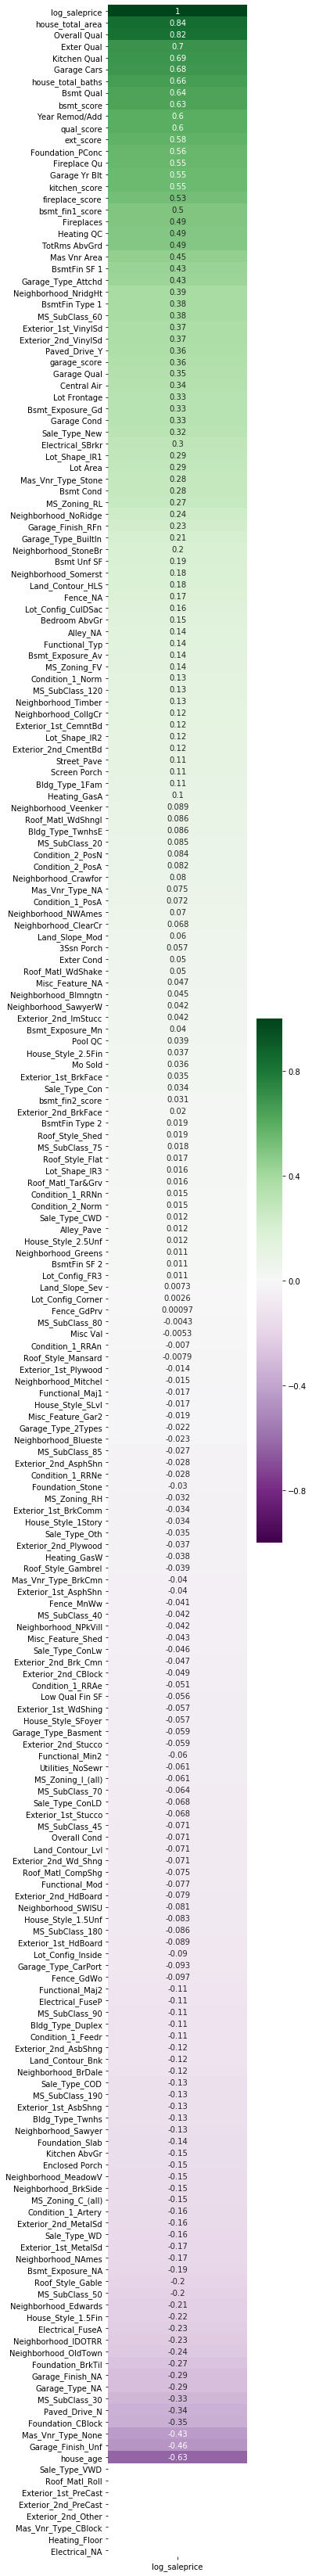

In [35]:
plt.figure(figsize=(4,60))
corr = train.drop(columns=ignore_cols).corr().sort_values(target, ascending = False)
sns.heatmap(corr[[target]], vmin = -1, annot = True, cmap="PRGn");

Again, the correlations seen make intuitive sense: variables related to a house's area, quality, and age have strong correlation with sales price. With the inclusion of the dummy variables, we can see more granular relationships, such as how the neighborhood a house is in plays a role. 

_NOTE: the missing correlations near the bottom correspond to the dummy variables create from the test dataset, and are not seen in the training set_

## Model Preparation

In [36]:
X = train.drop(columns = ignore_cols + [target])
y = train[target]

In [37]:
X.shape

(2034, 217)

## Fitting Model

### `getBestModel` Helper Function
This function simply takes a training and testing dataframe, creates a train/test split, scales the variables for regularization and pits a Linear Regressions, a Ridge, and a Lasso model against each other. It then returns the best one (optimizing for $R^2$) along with the StandardScalar already fit with the training data.

In [38]:
def getBestModel(df, test_df, cv = 5, random_state = 666):
    models = [
        LinearRegression(),
        RidgeCV(),
        LassoCV(cv = cv)
    ]
    
    X_train, X_test, y_train, y_test = train_test_split(df, test_df, random_state = 666)

    # Scaling
    scale = StandardScaler()
    X_train_sc = scale.fit_transform(X_train)
    X_test_sc = scale.transform(X_test)
    
    best_score = 0
    best_model = None
    for model in models:
        model.fit(X_train_sc, y_train)
        score = model.score(X_test_sc, y_test)
        if score > best_score:
            best_score = score
            best_model = model
    print(f"The best R^2 was: {best_score}")
    return (model, scale)

## Model Evaluation

In [39]:
best_model, scaler = getBestModel(X, y)

The best R^2 was: 0.9183429223662739


In [40]:
best_model

LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)

The best model ended up being a LASSO model with ~91.8% variance coverage.

### Plotting Predicted Sale Price vs. Actual Sale Price
Using the entire training set, I first used the fit StandardScaler to transform the dataset and then used my best model to predict the log(Sale Price). I will have to reverse-log (or exponentiate) the predicted value in order to return my predictions to the original scale of sale prices.

In [41]:
features_sc = scaler.transform(X)
predictions = best_model.predict(features_sc)

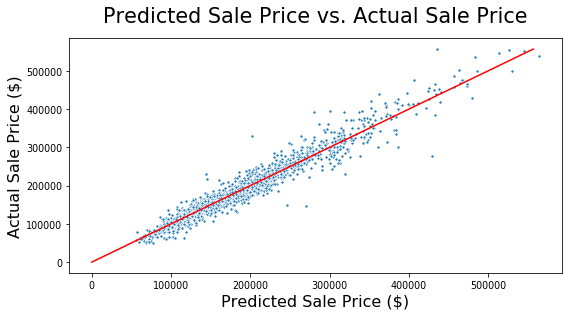

In [42]:
plt.figure(figsize=(8,4.5))
plt.title("Predicted Sale Price vs. Actual Sale Price", fontsize = size * 1.3, pad = size)
g = sns.scatterplot(np.exp(predictions), train["SalePrice"],  s=10);
g.set_xlabel("Predicted Sale Price ($)", size = size)
g.set_ylabel("Actual Sale Price ($)", size= size)
g.tick_params(labelsize=size * 3/5)
plt.tight_layout()
plt.plot([0,train["SalePrice"].max()], [0,train["SalePrice"].max()], color = "r");

### Plotting Residuals
Keeping with the original scale, I plotted the residuals by subracting the actual sale prices from the predicted sale prices.

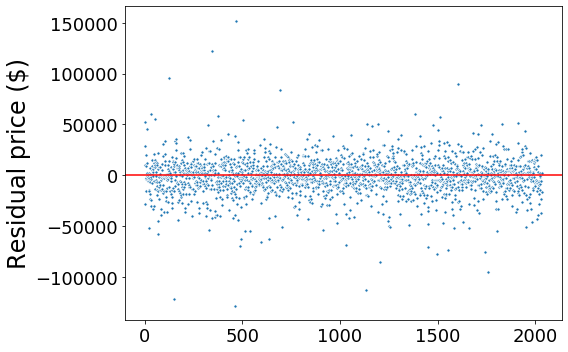

In [52]:
plt.figure(figsize=(8,5))
resids = np.exp(predictions) - train["SalePrice"]
g = sns.scatterplot(range(len(train["SalePrice"])),resids,  s=10);
g.set_ylabel("Residual price ($)", size= size * 1.5)
g.tick_params(labelsize=18)
plt.axhline(0, color = "r");
plt.tight_layout()

## Inferrential Statistics and Conclusions

### Model Coefficients

In [45]:
model_coefs = pd.DataFrame(best_model.coef_, index = X.columns)
model_coefs[abs(model_coefs[0]) > .014].sort_values(by=0, ascending=False)

,0
house_total_area,0.153049
qual_score,0.061773
bsmt_fin1_score,0.031409
Lot Area,0.020995
Kitchen Qual,0.018636
Overall Qual,0.017344
Neighborhood_Crawfor,0.015956
house_total_baths,0.015850
house_age,-0.064330


Looking as some of the most significant coefficients, we can see the most important features that govern a house's sale price. Again, we see some variables as expected, such as house area, quality, and age. However, some unexpected variables are also present.  

Having a __high scoring finished basement__ will play a large part in a house's sale price. This might suggest the functionality of having liveable basement space is a big benefit to the home owner. This may be unsurprising, though, as Ames is well known to be a college town with a high number of college students. Being able to utilize their basements allows home owners to maximize the amount of space they can rent out.  

Another surprising variable was the dummy variable for the __Crawford neighborhood__. Perhaps Ames residents would not be surprised by this, but all things being equal, a house in this neighborhood has a significant advantage and will tend to sell for more than houses in other neighborhoods. This suggests there are factors these data are not capturing fully, since neighborhoods are not easily quantifiable. Qualitative factors are likely at play here, such as the average income of local residents, education, age, demographics, number of children, etc.

### Model Assumptions
There are certian assumptions that come with a multiple regression model.  

One assumption is __the variables and the target are linearly related__. I'm confident this relationship is not violated, as the intuitive and common understanding of these housing variables is to be directly related to the house's sale price.

Another assumption is __the variables are independent from each other__. Below is a heatmap showing the correlations between the largest model coefficients. Simply put, this assumptions would be difficult to avoid, as many of these variables are intrinsicly related.

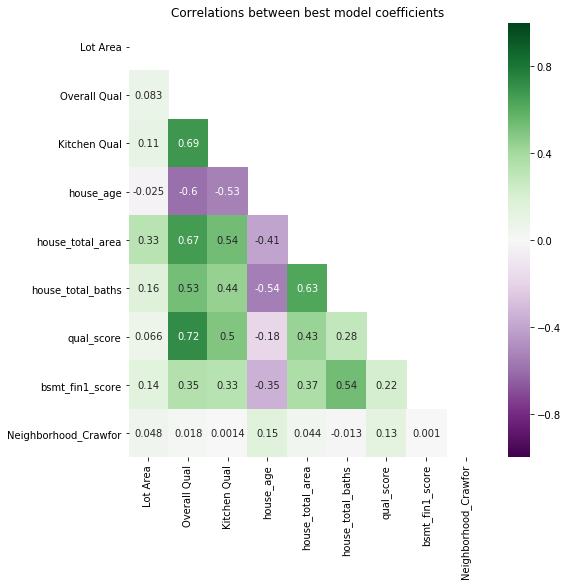

In [51]:
best_coefs = model_coefs[abs(model_coefs[0]) > .014].index
plt.figure(figsize=(8,8))
plt.title("Correlations between best model coefficients")
corr = train[best_coefs].corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, vmin = -1, annot = True, cmap="PRGn", mask = mask);

Another assumption is __the residuals are normally distributed around 0, independent, and have a constant variance__. Below is a histogram showing the normal-looking distribution of the residuals. 

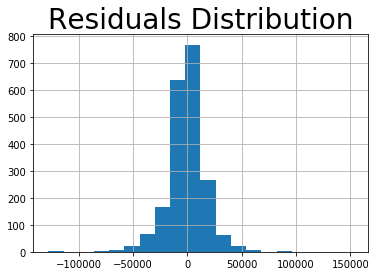

In [56]:
plt.title("Residuals Distribution", fontsize = 28)
resids.hist(bins = 20);

Also, in a previous residuals graph, the residuals showed a homoskedastic pattern, which suggests these assumptions are not violated.

I removed a number of outliers from the training dataset. For those erroneous outliers, I assume they were not significantly different from the rest of the data points. For those extreme outliers (more than 3 standard deviations from the mean), I am inherently fixing my model to predict on houses that do not show an extreme sale price. This means my model will likely be better at predicting typical houses, but will not accurately account for extremely high or low-end houses.

Lastly, these data are from 2006-2010, which is fairly old. In terms of predicting power, this model should be tested against more up-to-date information.

## Kaggle Submission

Using my model and the provided test set, I can make predictions for each house's sale price.  

So far, through feature creation and at other points in my workflow, whenever I've made a modification to the training set I've also appropriately done the same to the test set in order to stay consistent.

Before sending the test data through the model, I must transform it using the fitted ScalarStandard.  

Lastly, I will have to exponentiate the predicted results in order to keep them on the original scale for sale price.

In [44]:
ignore_cols.remove("SalePrice") # issue with SalePrice column not existing in Kaggle test dataset
kaggle_sc = scaler.transform(kaggle_test.drop(columns = ignore_cols))

# Must convert back to original price scale
kaggle_predicted = np.exp(best_model.predict(kaggle_sc))

final = pd.DataFrame(
    kaggle_predicted, 
    columns = ["SalePrice"], 
    index = kaggle_test.index
)

final.to_csv("datasets/submission.csv")

## Sources
1. [Data Dictionary](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt)
2. [Researching Feature Engineering]()https://nycdatascience.com/blog/student-works/machine-learning/machine-learning-project-ames-housing-dataset/